In [7]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers.training_args import BatchSamplers
import pandas as pd
from datasets import load_dataset, concatenate_datasets
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import torch
torch.set_float32_matmul_precision('high')
from collections import Counter
import matplotlib.pyplot as plt
import random

Mounted at /content/drive


In [3]:
df_unseen_test = pd.read_csv('/content/drive/Shareddrives/Master_Thesis/Data/unseen_test.csv')
df_train = pd.read_csv('/content/drive/Shareddrives/Master_Thesis/Data/train.csv')
df_test = pd.read_csv('/content/drive/Shareddrives/Master_Thesis/Data/test.csv')

print(len(df_unseen_test))
print(len(df_test))
print(len(df_train))
t=len(df_unseen_test)+len(df_test)+len(df_train)
print(t )


210
8668
79897
88775


In [4]:
df_train

,id,paper id,title,categories,type,content,question
0,130,2501.00784,cloitre's self-generating sequence,"['math.co', 'cs.dm', 'cs.fl', 'math.nt']",theorems,Let $g_n$ be the number of $1$'s in the sequen...,What is the limit of the proportion of 1's in ...
1,265,2501.00809,initial ideals of weighted forms and the genus...,"['math.ac', 'math.ag']",theorems,\label{ThmConjAreTrue}\nConjectures \ref{Conj1...,Does the statement of \textbf{ThmConjAreTrue} ...
2,266,2501.00809,initial ideals of weighted forms and the genus...,"['math.ac', 'math.ag']",propositions,}\n\newcommand{\ep}{,\\emph{Is the statement \emph{If $X$ is a comp...
3,267,2501.00809,initial ideals of weighted forms and the genus...,"['math.ac', 'math.ag']",definitions,}\n\newcommand{\ed}{,Is the statement $\ed{True}$?
4,313,2501.00845,spectral spaces of normal subgroups,"['math.gr', 'math.gn']",theorems,\label{mth}\nLet $G$ be a group having a maxim...,Does the set $\mathcal{N}^+(G)$ of proper norm...
...,...,...,...,...,...,...,...
79892,40568,2501.15565,homogeneity of rearrangement-invariant norms,['math.fa'],definitions,\label{D:Delta}\n\tLet $\mathcal Q$ be an inde...,What is the relationship between the set $\Del...
79893,57464,2502.02511,$\mathcal{h}^{1}$ and $\mathrm{bmo}$ regularit...,"['math.ap', 'math.ca']",lemmas,"\label{lem:pseudosmooth}\nLet $a\in S^{m}_{1,1...","Is the operator $a(x,D)$ in the theorem \label..."
79894,20658,2501.07874,"constrained differential operators, sobolev in...","['math.fa', 'math.ap']",theorems,"\label{K-CZ}\n Let $\alpha \in (0,n)$ and supp...",What is the kernel estimate for the convolutio...
79895,47493,2501.18053,varieties of prime tropical ideals and the dim...,"['math.ag', 'math.ac']",propositions,\label{prop: Iprime-bendPrime}\r\nLet $I$ be a...,Is Bend(I) prime for any prime ideal I of the ...


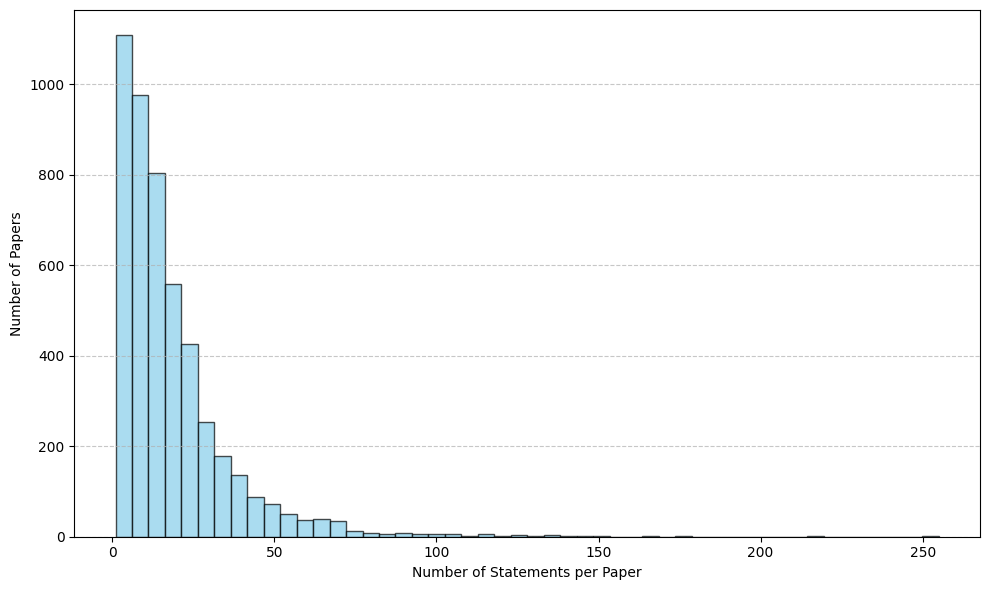

In [8]:
# Concatenate all dataframes (ignore index so we get a combined set)
df_all = pd.concat([df_train, df_test, df_unseen_test], ignore_index=True)

# Count statements per paper
statements_per_paper = df_all['paper id'].value_counts()

# Plot the distribution
plt.figure(figsize=(10,6))
plt.hist(statements_per_paper, bins=50, color='skyblue', edgecolor='k', alpha=0.7)
plt.xlabel('Number of Statements per Paper')
plt.ylabel('Number of Papers')
#plt.title('Distribution of Statements per Paper (All Data)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:
# Average number of statements per paper
average_statements = statements_per_paper.mean()
print(f"Average number of statements per paper: {average_statements:.2f}")

Average number of statements per paper: 18.33


Consider 3 models

## **SentenceTransformer Models**

These are full embedding pipelines. They:

- Load both model + tokenizer internally (wrapped together).

- Perform sentence-level embedding with pooling.

- Are used for retrieval, similarity, ranking, classification, etc.

For computing vector representations of full sentences or theorems.

In [11]:
# Fine-Tuned ModernBERT (already in sentence-transformers format, so no wrapping needed)
model_ft = SentenceTransformer("Master-thesis-NAP/ModernBERT-DAPT-Embed-DAPT-Math")

# Base ModernBERT (needs wrapping)
bert_base = models.Transformer("Master-thesis-NAP/ModernBert-DAPT-math")
pooling_base = models.Pooling(bert_base.get_word_embedding_dimension(), pooling_mode_mean_tokens=True)
model_base = SentenceTransformer(modules=[bert_base, pooling_base])

# MathBERT (also needs wrapping)
bert_math = models.Transformer("tbs17/MathBERT")
pooling_math = models.Pooling(bert_math.get_word_embedding_dimension(), pooling_mode_mean_tokens=True)
model_mathbert = SentenceTransformer(modules=[bert_math, pooling_math])

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:
# Inspect internal transformer layers of each SentenceTransformer model

raw_ft = model_ft[0].auto_model
raw_base = model_base[0].auto_model
raw_mathbert = model_mathbert[0].auto_model

# Inspect entire module hierarchy
print("\nFine-Tuned ModernBERT:")
print(raw_ft)

print("\nBase ModernBERT:")
print(raw_base)

print("\nMathBERT:")
print(raw_mathbert)



Fine-Tuned ModernBERT:
ModernBertModel(
  (embeddings): ModernBertEmbeddings(
    (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (drop): Dropout(p=0.0, inplace=False)
  )
  (layers): ModuleList(
    (0): ModernBertEncoderLayer(
      (attn_norm): Identity()
      (attn): ModernBertAttention(
        (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
        (rotary_emb): ModernBertRotaryEmbedding()
        (Wo): Linear(in_features=768, out_features=768, bias=False)
        (out_drop): Identity()
      )
      (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): ModernBertMLP(
        (Wi): Linear(in_features=768, out_features=2304, bias=False)
        (act): GELUActivation()
        (drop): Dropout(p=0.0, inplace=False)
        (Wo): Linear(in_features=1152, out_features=768, bias=False)
      )
    )
    (1-21): 21 x ModernBertEncoderLayer(
      (attn_norm): LayerN

In [8]:
# Access the underlying model from SentenceTransformer
raw_ft = model_ft[0].auto_model
raw_base = model_base[0].auto_model
raw_mathbert = model_mathbert[0].auto_model

# Inspect entire module hierarchy
print("\nFine-Tuned ModernBERT:")
print(raw_ft)

print("\nBase ModernBERT:")
print(raw_base)

print("\nMathBERT:")
print(raw_mathbert)



Fine-Tuned ModernBERT:
ModernBertModel(
  (embeddings): ModernBertEmbeddings(
    (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (drop): Dropout(p=0.0, inplace=False)
  )
  (layers): ModuleList(
    (0): ModernBertEncoderLayer(
      (attn_norm): Identity()
      (attn): ModernBertAttention(
        (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
        (rotary_emb): ModernBertRotaryEmbedding()
        (Wo): Linear(in_features=768, out_features=768, bias=False)
        (out_drop): Identity()
      )
      (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): ModernBertMLP(
        (Wi): Linear(in_features=768, out_features=2304, bias=False)
        (act): GELUActivation()
        (drop): Dropout(p=0.0, inplace=False)
        (Wo): Linear(in_features=1152, out_features=768, bias=False)
      )
    )
    (1-21): 21 x ModernBertEncoderLayer(
      (attn_norm): LayerN

In [9]:
print(model_base)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 8192, 'do_lower_case': False}) with Transformer model: ModernBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)


In [10]:
print(model_ft)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 8192, 'do_lower_case': False}) with Transformer model: ModernBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


In [11]:
print(model_mathbert)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)


## **Data**

In [12]:
# 1. Count how many theorems each paper has
counts = df_train['paper id'].value_counts()

# 2. Keep only papers with ≥ 10 theorems
eligible_papers = counts[counts >= 10].index.tolist()

# 3. Sample 10 papers (or adjust this number to get ~1000 points)
random.seed(42)
selected_papers = random.sample(eligible_papers, 10)

# 4. Filter the DataFrame to include those papers
df_subset = df_train[df_train['paper id'].isin(selected_papers)]

# Optional: limit to max 100 entries per paper for balance
df_subset = df_subset.groupby('paper id').apply(lambda x: x.sample(n=min(100, len(x)), random_state=42)).reset_index(drop=True)

print(f"Selected {len(selected_papers)} papers with {len(df_subset)} total theorems.")
df_subset.head()


Selected 10 papers with 272 total theorems.


<ipython-input-12-65cd89d5aad0>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_subset = df_subset.groupby('paper id').apply(lambda x: x.sample(n=min(100, len(x)), random_state=42)).reset_index(drop=True)


,id,paper id,title,categories,type,content,question
0,12625,2501.05071,fredholm anomalies on manifold with corners of...,"['math.kt', 'math.oa']",definitions,Let $D\in \Psi_b^m(X)$ be elliptic. We say tha...,Is the Fredholm Perturbation Property being st...
1,12601,2501.05071,fredholm anomalies on manifold with corners of...,"['math.kt', 'math.oa']",theorems,[Topological anomalies in codimension 2]\nLet ...,What is the condition for an elliptic b-pseudo...
2,12607,2501.05071,fredholm anomalies on manifold with corners of...,"['math.kt', 'math.oa']",theorems,"Let $\sigma \in K^1_{top}(^bT^*X)$, we have t...",What is the relationship between the induced m...
3,12608,2501.05071,fredholm anomalies on manifold with corners of...,"['math.kt', 'math.oa']",theorems,\label{Thmcnoddindexcodim3}\nLet $\sigma\in K^...,What is the relationship between the class of ...
4,12615,2501.05071,fredholm anomalies on manifold with corners of...,"['math.kt', 'math.oa']",corollaries,Let $D$ be an elliptic $b$-pseudodifferential ...,What is the condition for an elliptic b-pseudo...


## **Tokenization Analysis**

These are just tokenizers, not full models. They:

- Tokenize raw text into subword tokens (['Let', '$', 'D', ...])

- Allow you to inspect how each model "reads" or segments input text.

- Are useful for understanding token-level behavior, like:

 - token frequencies,

 - attention weights,

-  input sequence length.

Use these when analyzing the tokenization strategy (important for attention, sparsity, or equation boundary behavior)

In [13]:
from transformers import AutoTokenizer

text = df_subset['content'].iloc[0]

tok_ft = AutoTokenizer.from_pretrained("Master-thesis-NAP/ModernBERT-DAPT-Embed-DAPT-Math")
tok_base = AutoTokenizer.from_pretrained("Master-thesis-NAP/ModernBert-DAPT-math")
tok_mathbert = AutoTokenizer.from_pretrained("tbs17/MathBERT")

print("FT ModernBERT Tokens:", tok_ft.tokenize(text))
print("Base ModernBERT Tokens:", tok_base.tokenize(text))
print("MathBERT Tokens:", tok_mathbert.tokenize(text))

FT ModernBERT Tokens: ['Let', 'Ġ$', 'D', '\\', 'in', 'Ġ\\', 'Psi', '_', 'b', '^', 'm', '(', 'X', ')$', 'Ġbe', 'Ġelliptic', '.', 'ĠWe', 'Ġsay', 'Ġthat', 'Ġ$', 'D', '$', 'Ġsatisfies', ':', 'Ġ', 'Ċ', '\\', 'begin', '{', 'item', 'ize', '}', 'Ċ', '\\', 'item', '  ', 'the', 'Ġ{\\', 'it', 'ĠFred', 'holm', 'ĠP', 'ert', 'urb', 'ation', 'ĠProperty', '}', 'Ġ$(\\', 'c', 'F', '\\', 'c', 'P', ')$', 'Ġif', 'Ġthere', 'Ġis', '   ', '$', 'R', '\\', 'in', 'Ġ\\', 'Psi', '_', 'b', '^{-\\', 'infty', '}(', 'X', ')$', 'Ġsuch', 'Ġthat', 'Ġ$', 'D', '+', 'R', '$', 'Ġis', '  ', 'fully', 'Ġelliptic', '.', 'Ġ', 'Ċ', '\\', 'item', 'Ġthe', '  ', '{\\', 'it', 'Ġstably', '  ', 'Fred', 'holm', 'ĠP', 'ert', 'urb', 'ation', 'ĠProperty', '}', 'Ġ$(\\', 'c', 'S', '\\', 'c', 'F', '\\', 'c', 'P', ')$', 'Ġif', 'Ġ$', 'D', '\\', 'oplus', 'Ġ1', '_', 'H', '$', 'Ġsatisfies', 'Ġ$(\\', 'c', 'F', '\\', 'c', 'P', ')$', 'Ġfor', 'Ġsome', 'Ġidentity', 'Ġoperator', 'Ġ$', '1', '_', 'H', '$.', 'Ċ', '\\', 'item', 'Ġthe', 'Ġ{\\', 'it', 'Ġstably

In [14]:
text

"Let $D\\in \\Psi_b^m(X)$ be elliptic. We say that $D$ satisfies: \n\\begin{itemize}\n\\item  the {\\it Fredholm Perturbation Property} $(\\cF\\cP)$ if there is   $R\\in \\Psi_b^{-\\infty}(X)$ such that $D+R$ is  fully elliptic. \n\\item the  {\\it stably  Fredholm Perturbation Property} $(\\cS\\cF\\cP)$ if $D\\oplus 1_H$ satisfies $(\\cF\\cP)$ for some identity operator $1_H$.\n\\item the {\\it stably homotopic Fredholm Perturbation Property} $(\\cH\\cF\\cP)$ if there is a fully elliptic operator $D'$ with $[\\sigma_b(D')]=[\\sigma_b(D)]\\in K_0(C^*({}^bTX))$.\n\\end{itemize}"

In [15]:
print("Lengths:")
print("FT:", len(tok_ft.tokenize(text)))
print("Base:", len(tok_base.tokenize(text)))
print("MathBERT:", len(tok_mathbert.tokenize(text)))

Lengths:
FT: 211
Base: 211
MathBERT: 231


In [16]:
set_ft = set(tok_ft.tokenize(text))
set_base = set(tok_base.tokenize(text))
set_math = set(tok_mathbert.tokenize(text))

print("FT vs Base overlap:", len(set_ft & set_base))
print("FT vs MathBERT overlap:", len(set_ft & set_math))
print("Base vs MathBERT overlap:", len(set_base & set_math))


FT vs Base overlap: 91
FT vs MathBERT overlap: 23
Base vs MathBERT overlap: 23


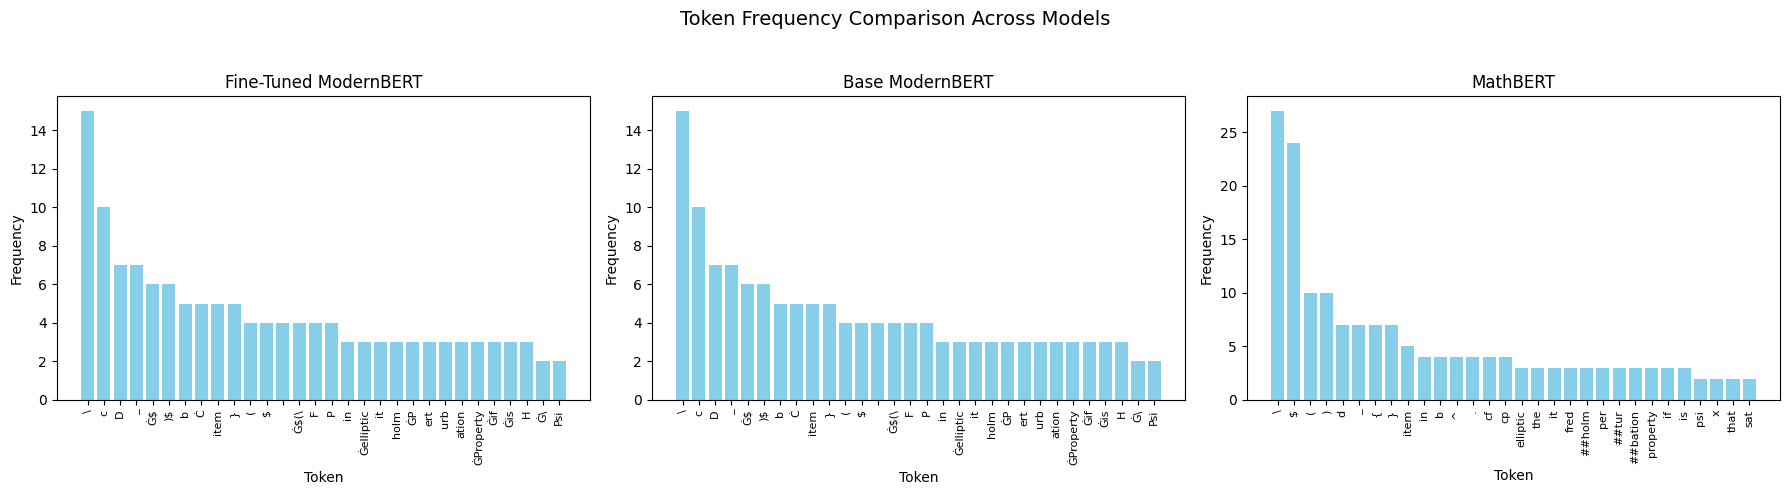

In [17]:
from collections import Counter
import matplotlib.pyplot as plt

# Use the tokenizers you've already instantiated
tokenizers = {
    "Fine-Tuned ModernBERT": tok_ft,
    "Base ModernBERT": tok_base,
    "MathBERT": tok_mathbert
}

text = df_subset['content'].iloc[0]
token_counts = {}

# Count token frequencies
for name, tokenizer in tokenizers.items():
    tokens = tokenizer.tokenize(text)
    token_counts[name] = Counter(tokens)

# Plot token frequency distribution (Top 30)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, counts) in zip(axes, token_counts.items()):
    top_tokens = dict(counts.most_common(30))
    ax.bar(top_tokens.keys(), top_tokens.values(), color='skyblue')
    ax.set_title(name, fontsize=12)
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Token")

plt.suptitle("Token Frequency Comparison Across Models", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## **Attention Map Comparison**

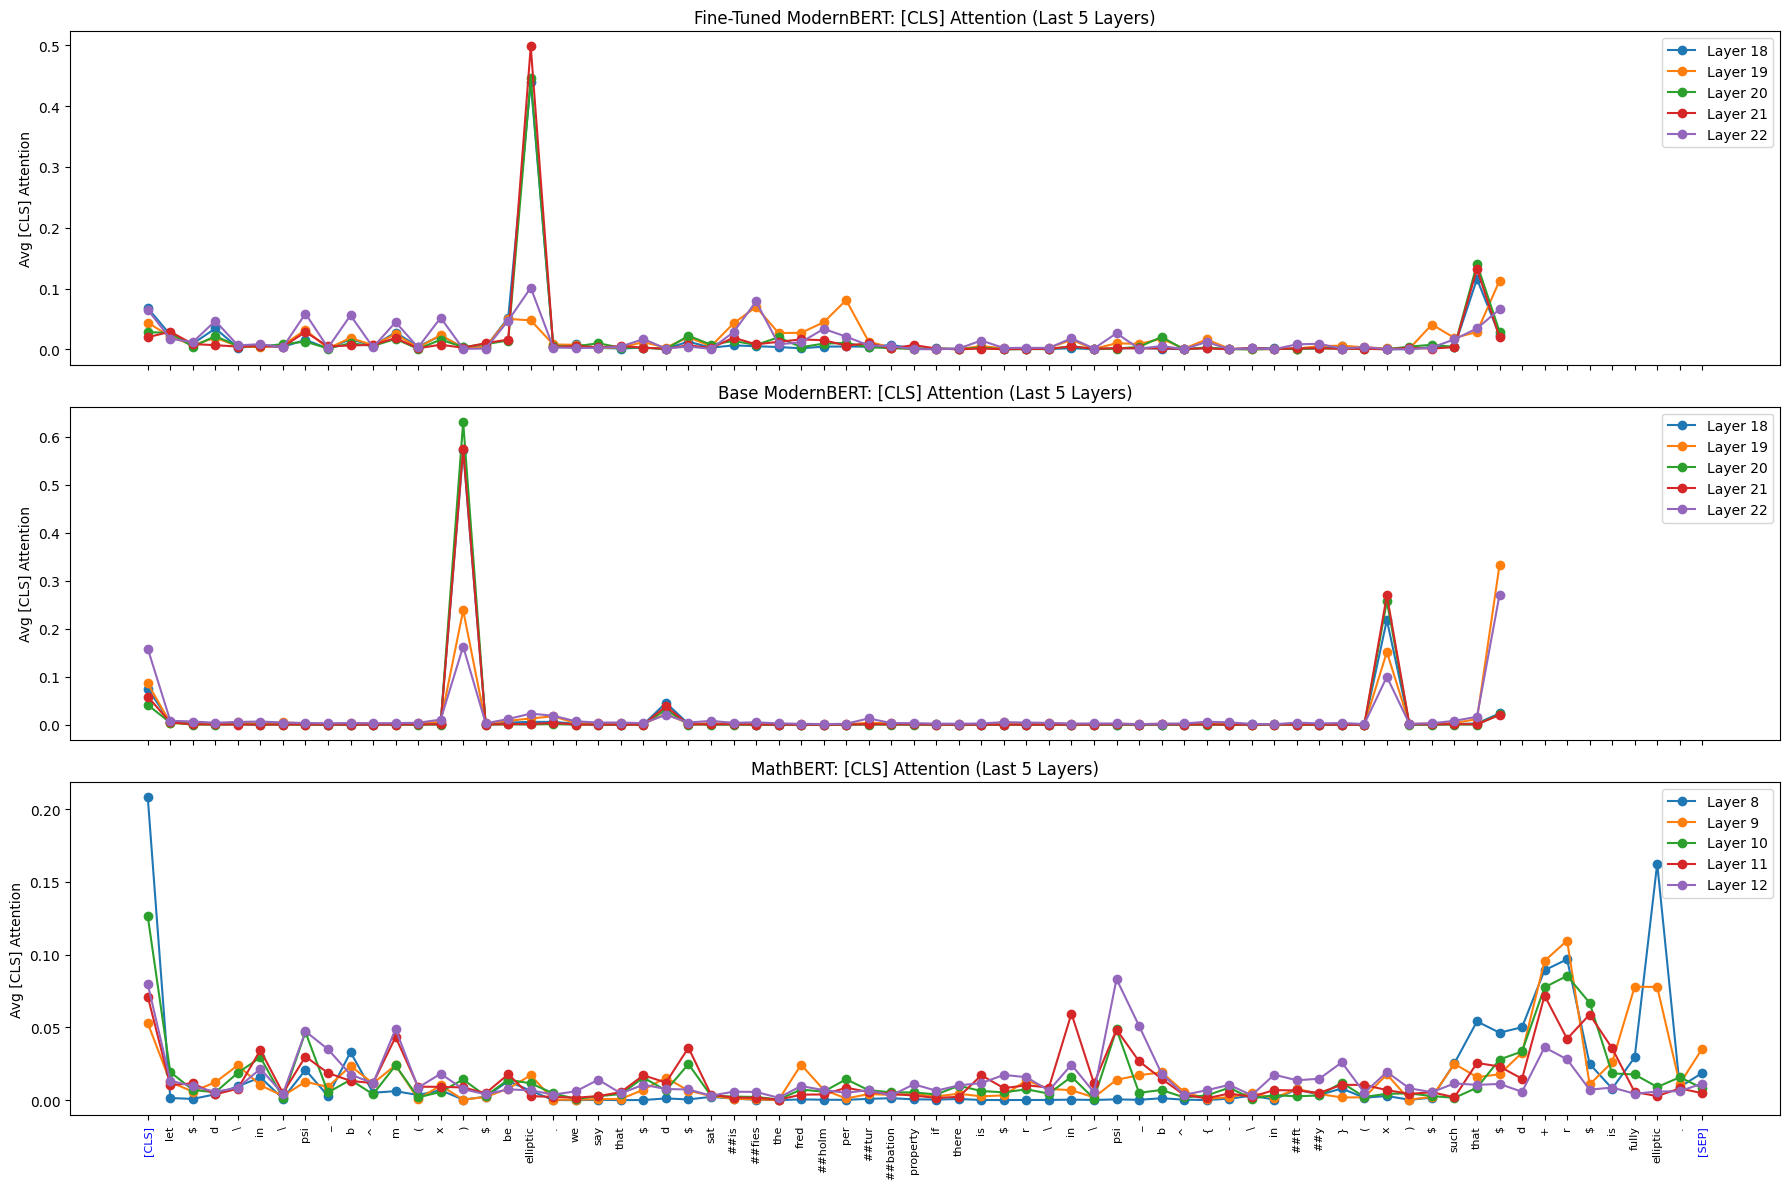

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_cls_attention_last5(model, tokenizer, text, ax, model_label):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        attentions = outputs.attentions  # List: one [batch, heads, seq, seq] per layer

    num_layers = len(attentions)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Plot the last 5 layers
    layers_to_plot = range(num_layers-5, num_layers)
    for layer in layers_to_plot:
        attn = attentions[layer][0]  # [heads, seq, seq]
        cls_attn = attn[:, 0, :]     # [heads, seq]
        avg_cls_attn = cls_attn.mean(axis=0).cpu().numpy()
        ax.plot(avg_cls_attn, marker="o", label=f"Layer {layer+1}")  # +1 for 1-based indexing

    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90, fontsize=8)
    ax.set_ylabel("Avg [CLS] Attention")
    ax.set_title(f"{model_label}: [CLS] Attention (Last 5 Layers)")
    ax.legend()

    # Optionally: color special tokens
    for label in ax.get_xticklabels():
        tok = label.get_text()
        if tok in ["[CLS]", "[SEP]"]:
            label.set_color("blue")

# Example usage for all models:
fig, axes = plt.subplots(len(transformer_models), 1, figsize=(18, 12), sharex=True)

for ax, (model_name, model) in zip(axes, transformer_models.items()):
    plot_cls_attention_last5(model, tokenizers[model_name], text, ax, model_name)

plt.tight_layout()
plt.show()


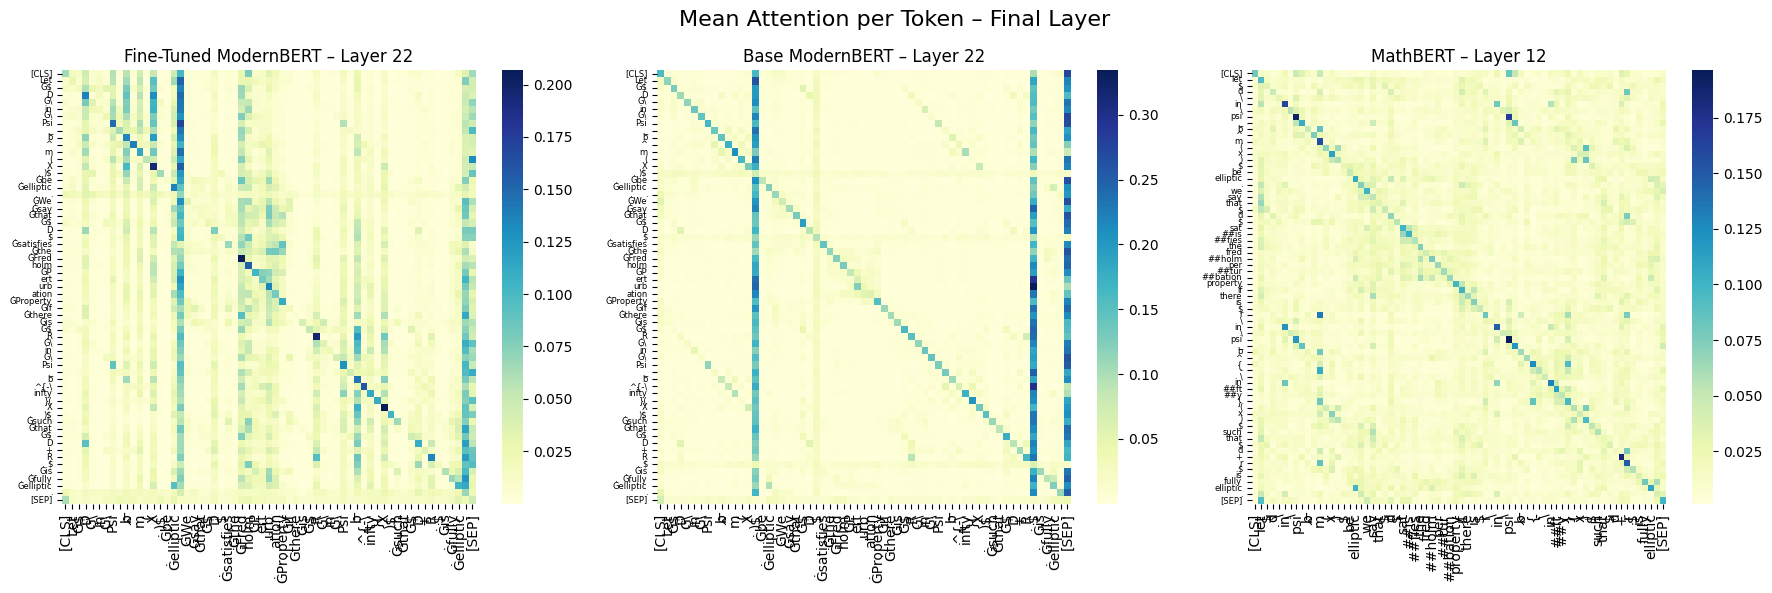

In [24]:
# Corresponding raw transformer models (for attention)
transformer_models = {
    "Fine-Tuned ModernBERT": AutoModel.from_pretrained("Master-thesis-NAP/ModernBERT-DAPT-Embed-DAPT-Math", output_attentions=True),
    "Base ModernBERT": AutoModel.from_pretrained("Master-thesis-NAP/ModernBert-DAPT-math", output_attentions=True),
    "MathBERT": AutoModel.from_pretrained("tbs17/MathBERT", output_attentions=True)
}

# You should already have your tokenizers dictionary set up
# tokenizers = {...}

# Optionally, you can auto-detect the last layer for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, model_name in zip(axes, transformer_models.keys()):
    model = transformer_models[model_name]
    tokenizer = tokenizers[model_name]
    model.eval()

    # Tokenize and forward
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        attentions = outputs.attentions  # List of [batch, num_heads, seq_len, seq_len]

    # Get last layer index dynamically
    last_layer_idx = len(attentions) - 1
    attn = attentions[last_layer_idx][0]  # [num_heads, seq_len, seq_len]

    # Mean attention over heads
    avg_attn = attn.mean(dim=0).cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Plot attention heatmap
    sns.heatmap(avg_attn, xticklabels=tokens, yticklabels=tokens, cmap="YlGnBu", ax=ax)
    ax.set_title(f"{model_name} – Layer {last_layer_idx+1}")  # +1 for human-readable (starts from 1)
    ax.tick_params(axis='x', rotation=90)
    ax.tick_params(axis='y', labelsize=6)

plt.suptitle(f"Mean Attention per Token – Final Layer", fontsize=16)
plt.tight_layout()
plt.show()


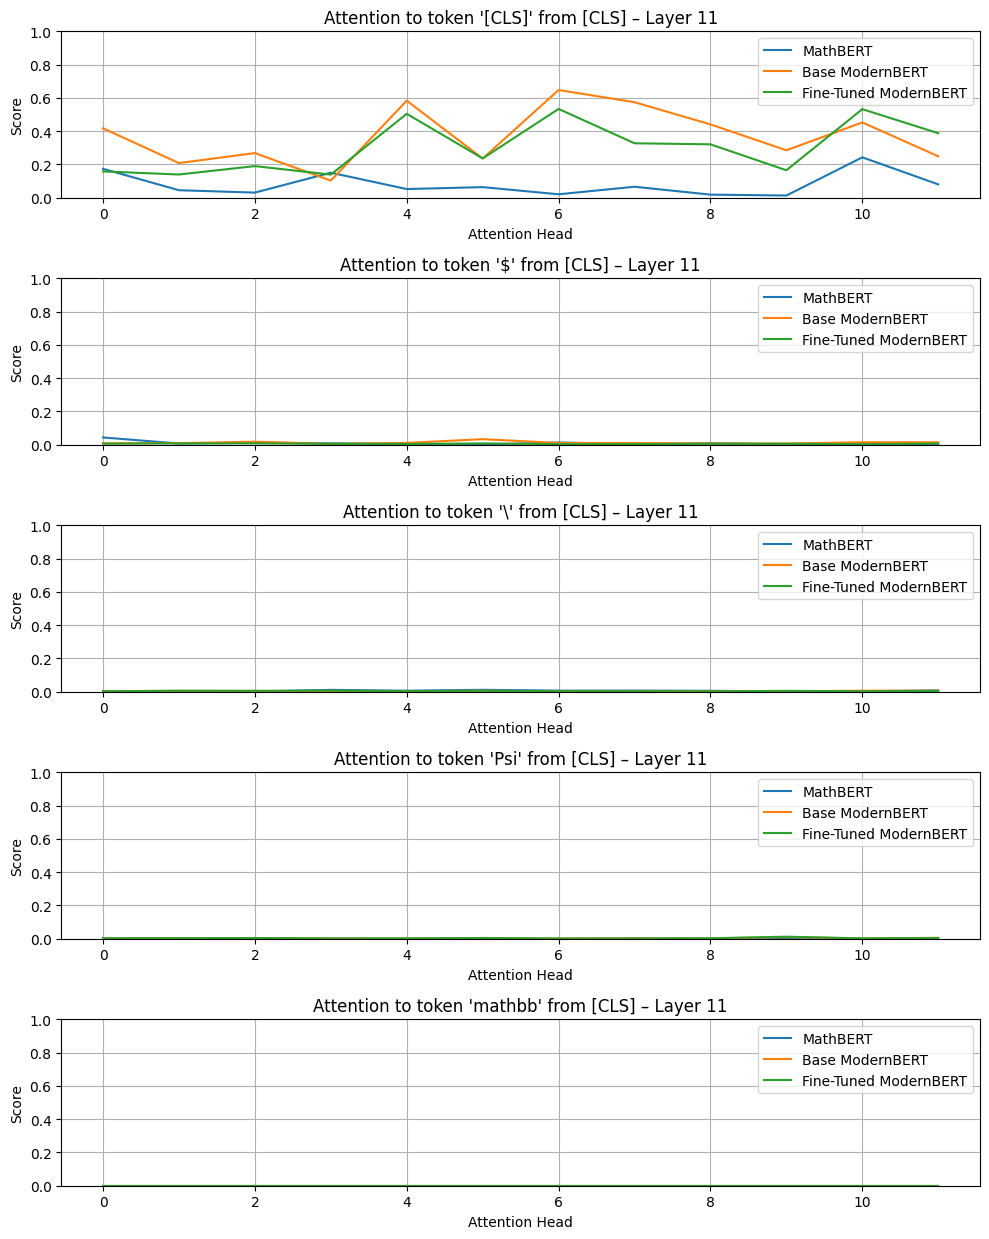

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from transformers import AutoModel, AutoTokenizer

# Set environment to limit threads (fix for some shared memory issues)
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

# Define model paths and LaTeX-rich text
model_paths = {
    "MathBERT": "tbs17/MathBERT",
    "Base ModernBERT": "Master-thesis-NAP/ModernBert-DAPT-math",
    "Fine-Tuned ModernBERT": "Master-thesis-NAP/ModernBERT-DAPT-Embed-DAPT-Math"
}

text = r"Let $D \in \Psi_b^m(X)$ be elliptic. We say that $D$ satisfies the Fredholm Perturbation Property if there is $R \in \Psi_b^{-\infty}(X)$ such that $D+R$ is fully elliptic."

layer = 11  # Target encoder layer
target_tokens = ["[CLS]", "$", "\\", "Psi", "mathbb"]

# Container to store all attention data
attention_data = {}

# Loop through models and extract attention
for model_name, path in model_paths.items():
    tokenizer = AutoTokenizer.from_pretrained(path)
    model = AutoModel.from_pretrained(path, output_attentions=True)
    model.eval()

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        attentions = outputs.attentions[layer][0]  # Shape: [heads, seq_len, seq_len]

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    cls_attn = attentions[:, 0, :].numpy()  # Attention from [CLS] to all tokens
    token_attn_dict = {}

    for token in target_tokens:
        matches = [i for i, tok in enumerate(tokens) if token in tok]
        if matches:
            avg_attn = np.mean(cls_attn[:, matches], axis=1)
            token_attn_dict[token] = avg_attn
        else:
            token_attn_dict[token] = np.zeros(cls_attn.shape[0])

    attention_data[model_name] = token_attn_dict

# Plot all tokens per model
fig, axes = plt.subplots(len(target_tokens), 1, figsize=(10, 2.5 * len(target_tokens)))

for idx, token in enumerate(target_tokens):
    ax = axes[idx]
    for model_name in model_paths:
        values = attention_data[model_name][token]
        ax.plot(values, label=model_name)
    ax.set_title(f"Attention to token '{token}' from [CLS] – Layer {layer}")
    ax.set_xlabel("Attention Head")
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


## **EMBEDDING STRUCTURE**

In [27]:
from sentence_transformers import SentenceTransformer, models

word_model = models.Transformer("Master-thesis-NAP/ModernBERT-DAPT-Embed-DAPT-Math")
pooling = models.Pooling(word_model.get_word_embedding_dimension())
model_ft_wo_norm = SentenceTransformer(modules=[word_model, pooling])

In [29]:
texts = df_subset['content'].tolist()

emb_ft_wo_norm = model_ft_wo_norm.encode(texts, convert_to_numpy=True, show_progress_bar=True)
emb_base = model_base.encode(texts, convert_to_numpy=True, show_progress_bar=True)
emb_mathbert = model_mathbert.encode(texts, convert_to_numpy=True, show_progress_bar=True)

print("FT Embeddings:", emb_ft_wo_norm.shape)

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

FT Embeddings: (272, 768)


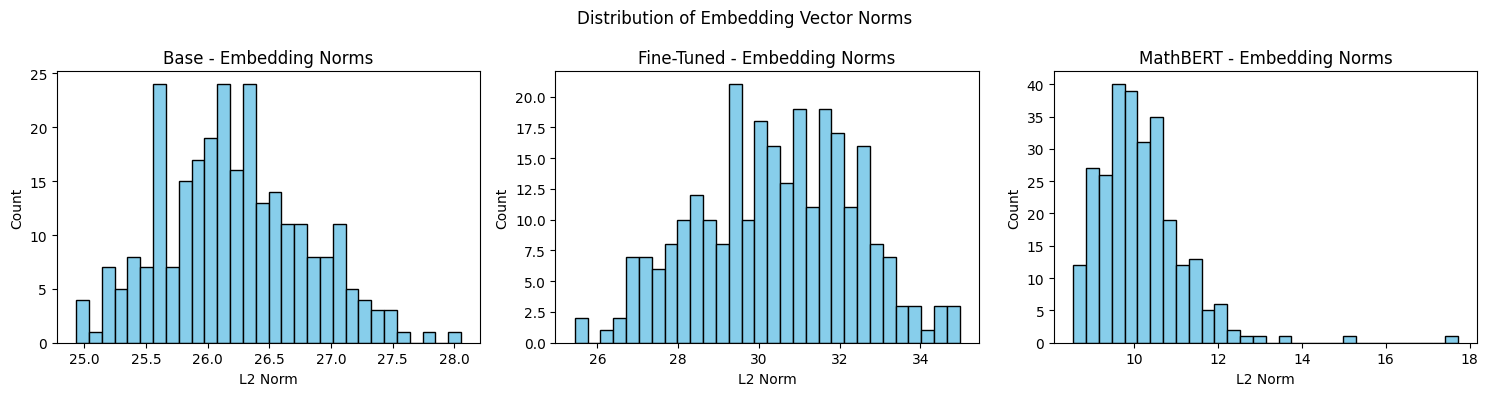

In [30]:
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (emb, title) in zip(
    axes,
    [(emb_base, "Base"), (emb_ft_wo_norm, "Fine-Tuned"), (emb_mathbert, "MathBERT")]
):
    norms = np.linalg.norm(emb, axis=1)
    ax.hist(norms, bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f"{title} - Embedding Norms")
    ax.set_xlabel("L2 Norm")
    ax.set_ylabel("Count")

plt.suptitle("Distribution of Embedding Vector Norms")
plt.tight_layout()
plt.show()


## **Compute Cosine Similarities**

In [35]:
from sentence_transformers.util import cos_sim
import torch

# Encode (already done)
emb_ft = model_ft.encode(texts, convert_to_numpy=True, show_progress_bar=True)
emb_base = model_base.encode(texts, convert_to_numpy=True, show_progress_bar=True)
emb_mathbert = model_mathbert.encode(texts, convert_to_numpy=True, show_progress_bar=True)

# Convert numpy arrays to torch tensors
emb_ft_torch = torch.tensor(emb_ft)
emb_base_torch = torch.tensor(emb_base)
emb_mathbert_torch = torch.tensor(emb_mathbert)

# Cosine similarity matrices
sim_matrix_ft = cos_sim(emb_ft_torch, emb_ft_torch).cpu().numpy()
sim_matrix_base = cos_sim(emb_base_torch, emb_base_torch).cpu().numpy()
sim_matrix_mathbert = cos_sim(emb_mathbert_torch, emb_mathbert_torch).cpu().numpy()


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

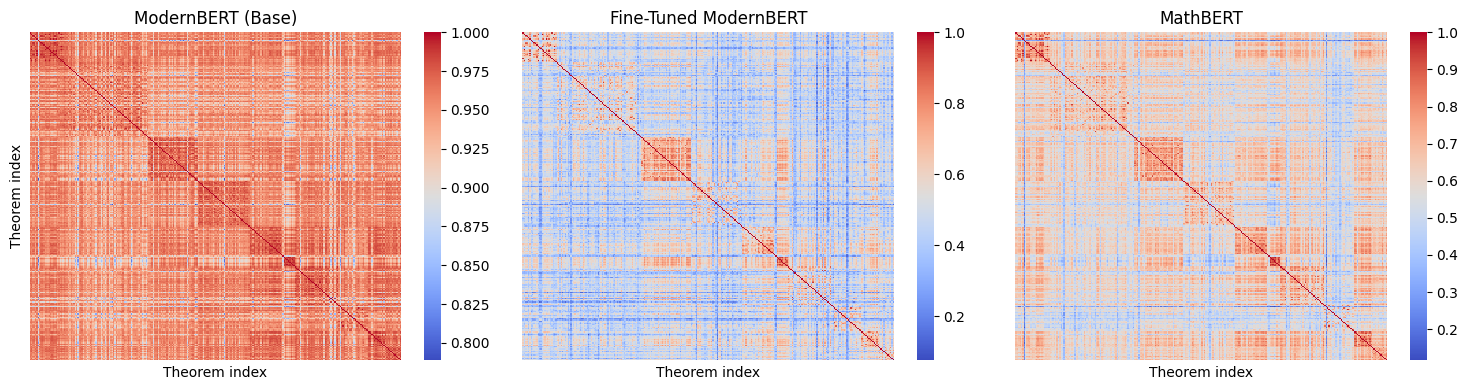

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

matrices = [
    (sim_matrix_base, "ModernBERT (Base)"),
    (sim_matrix_ft, "Fine-Tuned ModernBERT"),
    (sim_matrix_mathbert, "MathBERT")
]

for ax, (matrix, title) in zip(axes, matrices):
    sns.heatmap(matrix, ax=ax, cmap="coolwarm", xticklabels=False, yticklabels=False)
    ax.set_title(title)
    ax.set_xlabel("Theorem index")
    ax.set_ylabel("")

axes[0].set_ylabel("Theorem index")
#plt.suptitle("Cosine Similarity Heatmaps", fontsize=14)
plt.tight_layout()
plt.show()

## **PSA**

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

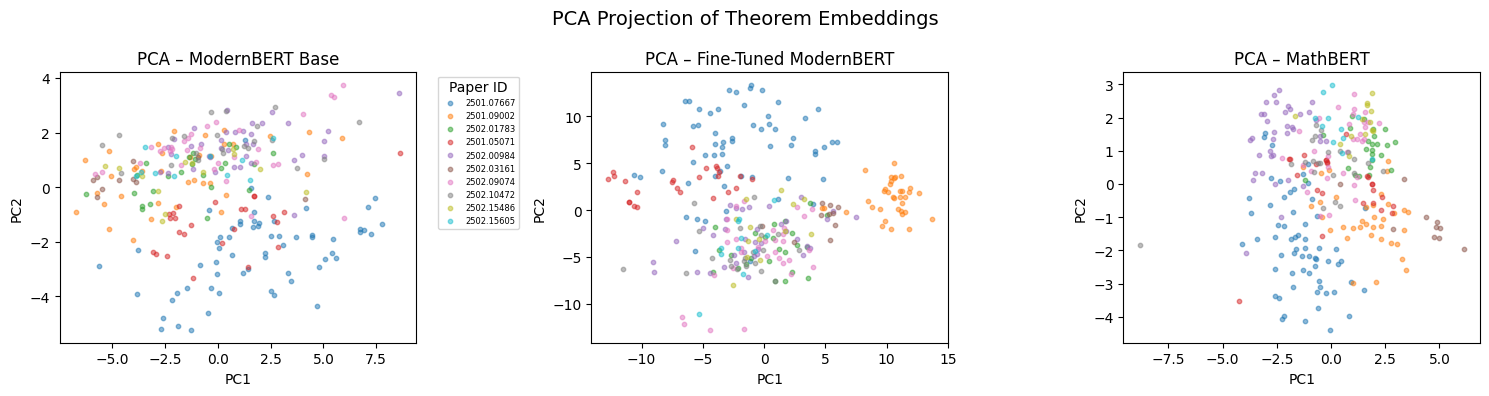

In [33]:
from sklearn.decomposition import PCA

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Embeddings from models *without* the Normalize() layer
emb_ft_wo_norm = model_ft_wo_norm.encode(texts, convert_to_numpy=True, show_progress_bar=True)
emb_base = model_base.encode(texts, convert_to_numpy=True, show_progress_bar=True)  # Already unnormalized
emb_mathbert = model_mathbert.encode(texts, convert_to_numpy=True, show_progress_bar=True)  # Already unnormalized

models_pca = [
    (emb_base, "PCA – ModernBERT Base"),
    (emb_ft_wo_norm, "PCA – Fine-Tuned ModernBERT"),
    (emb_mathbert, "PCA – MathBERT")
]

for ax, (embeddings, title) in zip(axes, models_pca):
    proj = PCA(n_components=2).fit_transform(embeddings)
    for paper in set(df_subset['paper id']):
        idxs = [i for i, p in enumerate(df_subset['paper id']) if p == paper]
        ax.scatter(proj[idxs, 0], proj[idxs, 1], label=str(paper), alpha=0.5, s=10)
    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

axes[0].legend(fontsize=6, title="Paper ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle("PCA Projection of Theorem Embeddings", fontsize=14)
plt.tight_layout()
plt.show()


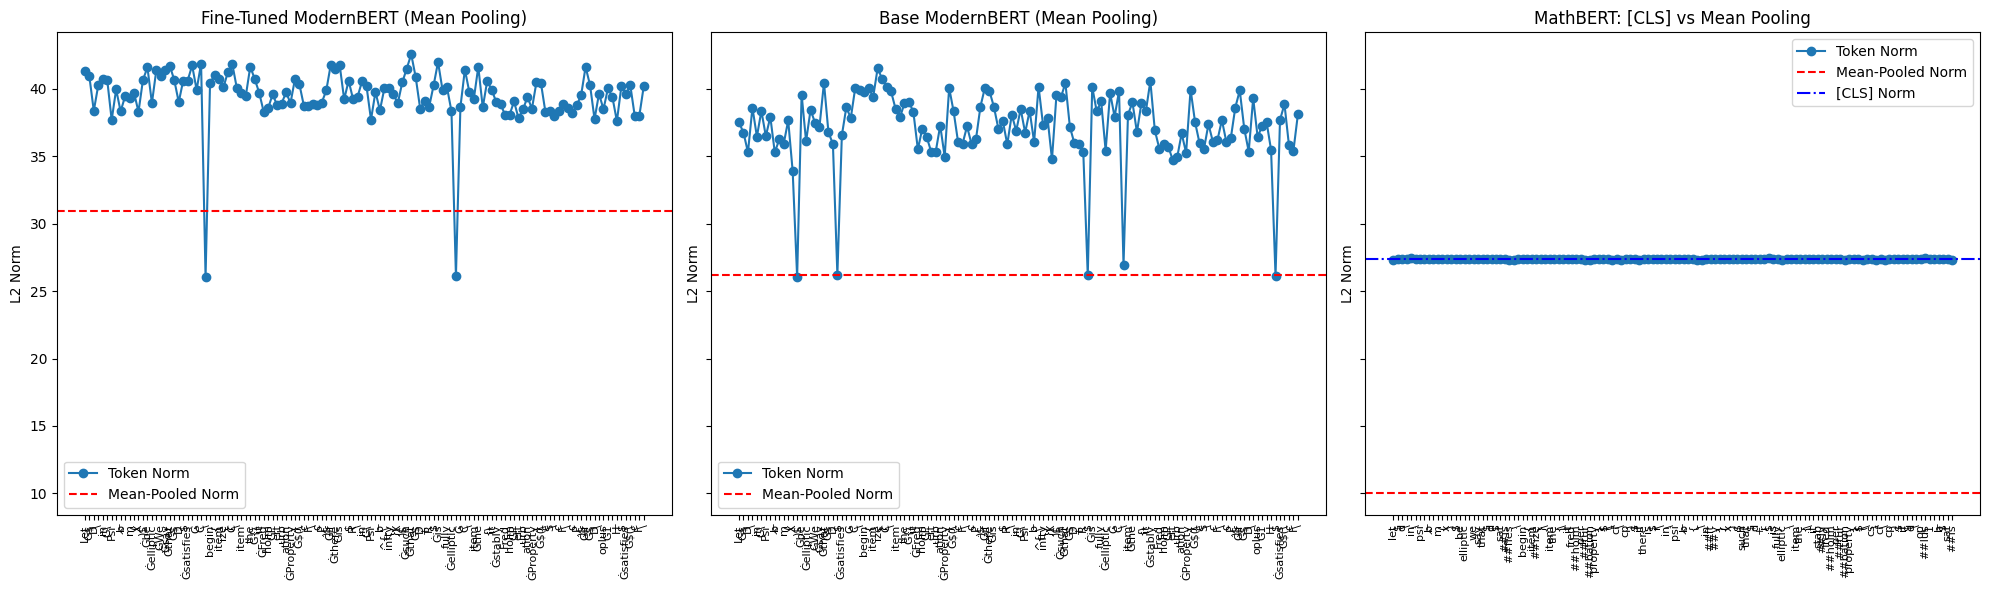

In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_pooling(model, tokenizer, text, ax, title):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}  # move to device

    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden = outputs.last_hidden_state[0].cpu()  # shape: [seq_len, hidden_dim]
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu())

    # Exclude special tokens [CLS], [SEP] for mean pooling
    keep_idx = [i for i, tok in enumerate(tokens) if tok not in ["[CLS]", "[SEP]"]]
    tokens_no_special = [tokens[i] for i in keep_idx]
    hidden_no_special = last_hidden[keep_idx]

    # Compute norms
    token_norms = hidden_no_special.norm(dim=1).numpy()
    mean_pooled = hidden_no_special.mean(dim=0)
    mean_norm = mean_pooled.norm().item()

    # Plot
    ax.plot(range(len(tokens_no_special)), token_norms, marker='o', label='Token Norm')
    ax.axhline(mean_norm, color='red', linestyle='--', label='Mean-Pooled Norm')
    ax.set_xticks(range(len(tokens_no_special)))
    ax.set_xticklabels(tokens_no_special, rotation=90, fontsize=8)
    ax.set_ylabel("L2 Norm")
    ax.set_title(f"{title} (Mean Pooling)")
    ax.legend()

def plot_mathbert_pooling(model, tokenizer, text, ax):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}  # move to device

    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden = outputs.last_hidden_state[0].cpu()
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu())

    cls_embedding = last_hidden[0]
    cls_norm = cls_embedding.norm().item()

    keep_idx = [i for i, tok in enumerate(tokens) if tok not in ["[CLS]", "[SEP]"]]
    tokens_no_special = [tokens[i] for i in keep_idx]
    hidden_no_special = last_hidden[keep_idx]

    token_norms = hidden_no_special.norm(dim=1).numpy()
    mean_pooled = hidden_no_special.mean(dim=0)
    mean_norm = mean_pooled.norm().item()

    ax.plot(range(len(tokens_no_special)), token_norms, marker='o', label='Token Norm')
    ax.axhline(mean_norm, color='red', linestyle='--', label='Mean-Pooled Norm')
    ax.axhline(cls_norm, color='blue', linestyle='-.', label='[CLS] Norm')
    ax.set_xticks(range(len(tokens_no_special)))
    ax.set_xticklabels(tokens_no_special, rotation=90, fontsize=8)
    ax.set_ylabel("L2 Norm")
    ax.set_title("MathBERT: [CLS] vs Mean Pooling")
    ax.legend()

# Make sure your models/tokenizers are loaded and moved to the right device!
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

plot_mean_pooling(raw_ft, tok_ft, example_text, axes[0], "Fine-Tuned ModernBERT")
plot_mean_pooling(raw_base, tok_base, example_text, axes[1], "Base ModernBERT")
plot_mathbert_pooling(raw_mathbert, tok_mathbert, example_text, axes[2])

#plt.suptitle("Token Embedding Norms vs. Sentence Embedding ([CLS] for MathBERT)")
plt.tight_layout()
plt.show()

